# Bee segmentation, removal, and timelapse algorithms

### Notes for use:
For the code chunks below, those marked with EDIT require a change in the code for your files to run properly. If there is no edit marking above a code section, the code can be run as is. These are usually chunks with function set ups. For ease of access, all lines that need to be changed have been marked with a 'TODO' tag. You can easily find these by hitting CTRL + F and searching the file.

## Imports required for the methods below
The second code chunk is the necessary imports for the rest of the code. The first code chunk may be necessary if the python kernel keeps crashing, but otherwise can be ignored.

In [1]:
#kernel kept crashing, was suggested to use this to fix -Emily
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# Importing necessary libraries
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import segmentation_models_pytorch as smp
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# import matplotlib.image as mpimg
# import torch.optim as optim
# import sys
# from tqdm import tqdm as tqdm

## Import data to train the model

Data has been annotated to train the data on where to detect bees in an image.

In [3]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

# GitHub repository URL
github_repo_url = "https://github.com/enhatl/Capstone-Project"

# Function to get raw file URL
def get_raw_file_url(repo_url, file_path):
    return f"{repo_url}/raw/main/{file_path}"

# Define the data directory
DATA_DIR = os.path.join(os.getcwd(), "Data")  # Save directly to the 'Data' folder in the current working directory

# Define the subfolders
subfolders = ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test']

class SegmentationDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, transform=None):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
        self.ids = os.listdir(imgs_dir)
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_dir, self.ids[idx])
        mask_path = os.path.join(self.masks_dir, self.ids[idx].replace(".jpg", ".png"))
        
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        mask = (mask > 127).astype(np.float32)  # Convert mask to binary 0 and 1
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'][None]
            
        return image, mask

# Define transformations
# Training transformations with augmentations
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomRotate90(),
    A.Flip(),
    A.Transpose(),
    A.OneOf([
        A.ElasticTransform(p=0.1),
        A.GridDistortion(p=0.1),
        A.OpticalDistortion(p=0.1)
    ], p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Validation and test transformations without augmentations
valid_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Apply the transformations to the datasets
x_train_dir = os.path.join(DATA_DIR, 'X_train')
y_train_dir = os.path.join(DATA_DIR, 'y_train')
x_valid_dir = os.path.join(DATA_DIR, 'X_val')
y_valid_dir = os.path.join(DATA_DIR, 'y_val')
x_test_dir = os.path.join(DATA_DIR, 'X_test')
y_test_dir = os.path.join(DATA_DIR, 'y_test')

train_dataset = SegmentationDataset(x_train_dir, y_train_dir, train_transform)
valid_dataset = SegmentationDataset(x_valid_dir, y_valid_dir, valid_transform)
test_dataset = SegmentationDataset(x_test_dir, y_test_dir, valid_transform)


### Set-up for the model

In [4]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self, logits, targets):
        # logits: predictions (after sigmoid or softmax)
        # targets: ground truth
        
        # Convert logits to binary predictions
        probs = torch.sigmoid(logits)
        
        # Flatten the tensors
        num = targets.size(0)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        
        intersection = (m1 * m2).sum()
        
        return 1 - (2. * intersection + self.eps) / (m1.sum() + m2.sum() + self.eps)


In [5]:
# Define the model and training specifics:

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
# ACTIVATION = 'sigmoid'
ACTIVATION = 'sigmoid'
DECODER = 'UnetPlusPlus' 

model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=3, 
    classes=1, 
    activation=ACTIVATION
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = nn.BCELoss()
#criterion = DiceLoss().to(device)




num_epochs = 100
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/enhatl/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 32.0MB/s]


### Defining scoring metrics for the model (accuracy, IOU, etc.)

In [6]:
# Implement the metrics:
def iou_score(output, target):
    smooth = 1e-5
    # Remove single-dimension entries from the shape of an array.
    output = torch.squeeze(output)
    target = torch.squeeze(target)
    intersection = (output & target).float().sum()
    union = (output | target).float().sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()


def get_metrics(output, target):
    output = output.squeeze().detach().cpu().numpy()
    target = target.squeeze().detach().cpu().numpy()

    output = (output > 0.5).astype(np.uint8)
    target = target.astype(np.uint8)
    
    iou = iou_score(torch.tensor(output), torch.tensor(target))
    accuracy = accuracy_score(target.ravel(), output.ravel())
    recall = recall_score(target.ravel(), output.ravel())
    precision = precision_score(target.ravel(), output.ravel())
    f_score = f1_score(target.ravel(), output.ravel())
    
    return iou, accuracy, recall, precision, f_score


## Training of the model

### EDIT

The model_path will need to be updated for your personal computer. Any folder will suffice, but the path will need to be named. We used 'UNETPLUSPLUS_model.pth', but any name that ends with .pth will work. Note: this is a large file so it is not able to be uploaded to the github repository.

There is one line to change at the top.

In [8]:
#  Train the model:


# For early stopping based on accuracy
best_accuracy = 0.0
epochs_without_improvement = 0

#TODO: change to local folder
model_path = "/Users/enhatl/Desktop/Capstone Proj/UNETPLUSPLUS_model.pth" 

# For decreasing the learning rate after 3 epochs
scheduler = StepLR(optimizer, step_size=6, gamma=0.4)

for epoch in range(num_epochs):
    model.train()
    
    # Training phase
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Evaluation phase
    model.eval()
    valid_loss, total_iou, total_acc, total_recall, total_precision, total_fscore = 0, 0, 0, 0, 0,0
    with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            valid_loss += loss.item()

            iou, accuracy, recall, precision, f_score = get_metrics(outputs, masks)
            
            total_iou += iou
            total_acc += accuracy
            total_recall += recall
            total_precision += precision
            total_fscore += f_score

    valid_loss /= len(valid_loader)
    avg_iou = total_iou / len(valid_loader)
    avg_acc = total_acc / len(valid_loader)

    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, IoU: {avg_iou:.4f}, Acc: {avg_acc:.4f}, Recall: {total_recall/len(valid_loader):.4f}, Precision: {total_precision/len(valid_loader):.4f}, F1: {total_fscore/len(valid_loader):.4f}")

    # Check if accuracy improved
    if avg_acc > best_accuracy:
        best_accuracy = avg_acc
        torch.save(model.state_dict(), model_path)
        print("Best model saved with accuracy:", best_accuracy)
        epochs_without_improvement = 0
        
        
    else:
        epochs_without_improvement += 1

    # Early stopping based on accuracy
    if epochs_without_improvement == 50:
        print("Early stopping triggered after 50 epochs without accuracy improvement.")
        break

    # Step the scheduler (decrease the learning rate after each epoch)
    scheduler.step()


Epoch: 1, Train Loss: 0.6145, Valid Loss: 1.3316, IoU: 0.3250, Acc: 0.6085, Recall: 0.4768, Precision: 0.5052, F1: 0.4906
Best model saved with accuracy: 0.6085205078125
Epoch: 2, Train Loss: 0.5335, Valid Loss: 13.9269, IoU: 0.0000, Acc: 0.6046, Recall: 0.0000, Precision: 0.5000, F1: 0.0000
Epoch: 3, Train Loss: 0.4903, Valid Loss: 6.2826, IoU: 0.0029, Acc: 0.6056, Recall: 0.0029, Precision: 0.8916, F1: 0.0057
Epoch: 4, Train Loss: 0.4993, Valid Loss: 1.0919, IoU: 0.3552, Acc: 0.5183, Recall: 0.6713, Precision: 0.4300, F1: 0.5242
Epoch: 5, Train Loss: 0.4894, Valid Loss: 2.2533, IoU: 0.3603, Acc: 0.5322, Recall: 0.6664, Precision: 0.4396, F1: 0.5298
Epoch: 6, Train Loss: 0.5263, Valid Loss: 8.2960, IoU: 0.0645, Acc: 0.6053, Recall: 0.0688, Precision: 0.5067, F1: 0.1212
Epoch: 7, Train Loss: 0.5024, Valid Loss: 4.7227, IoU: 0.0861, Acc: 0.6239, Recall: 0.0896, Precision: 0.6862, F1: 0.1586
Best model saved with accuracy: 0.6238632202148438
Epoch: 8, Train Loss: 0.4679, Valid Loss: 1.95

## Testing of the data set and performance metrics


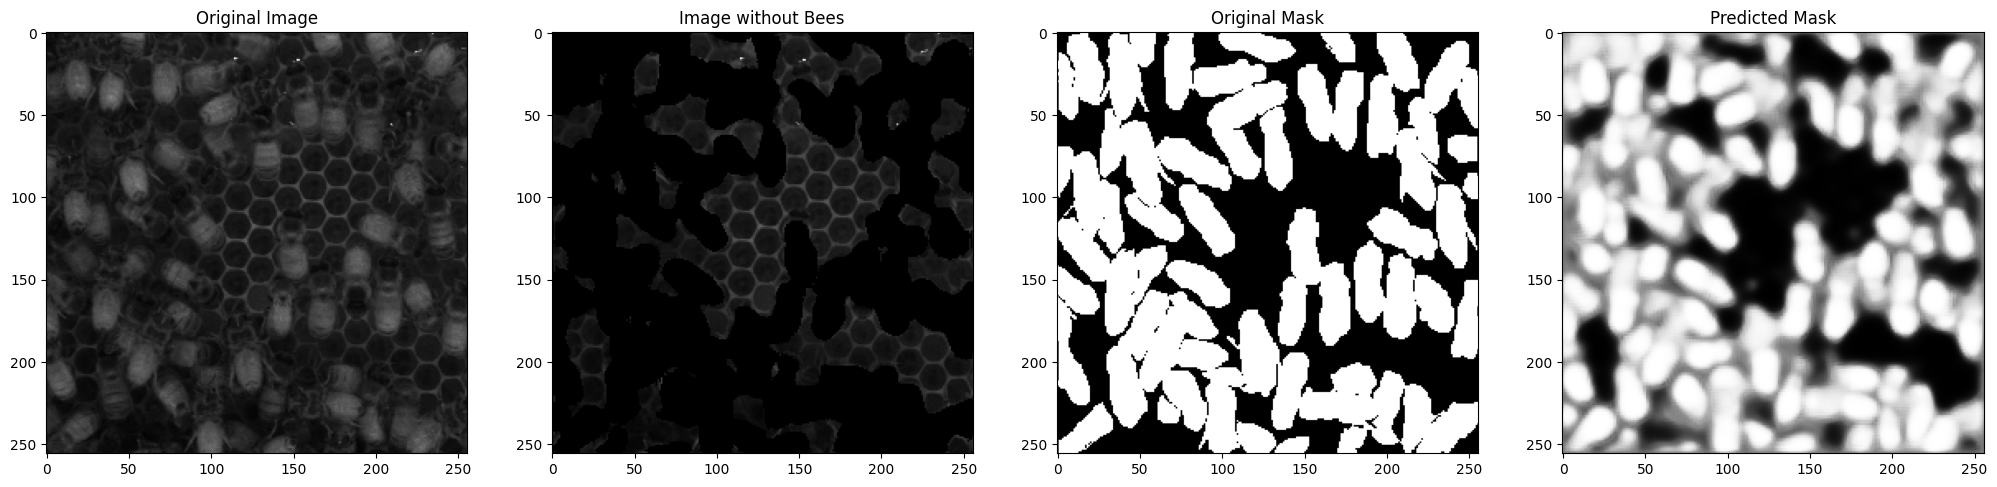

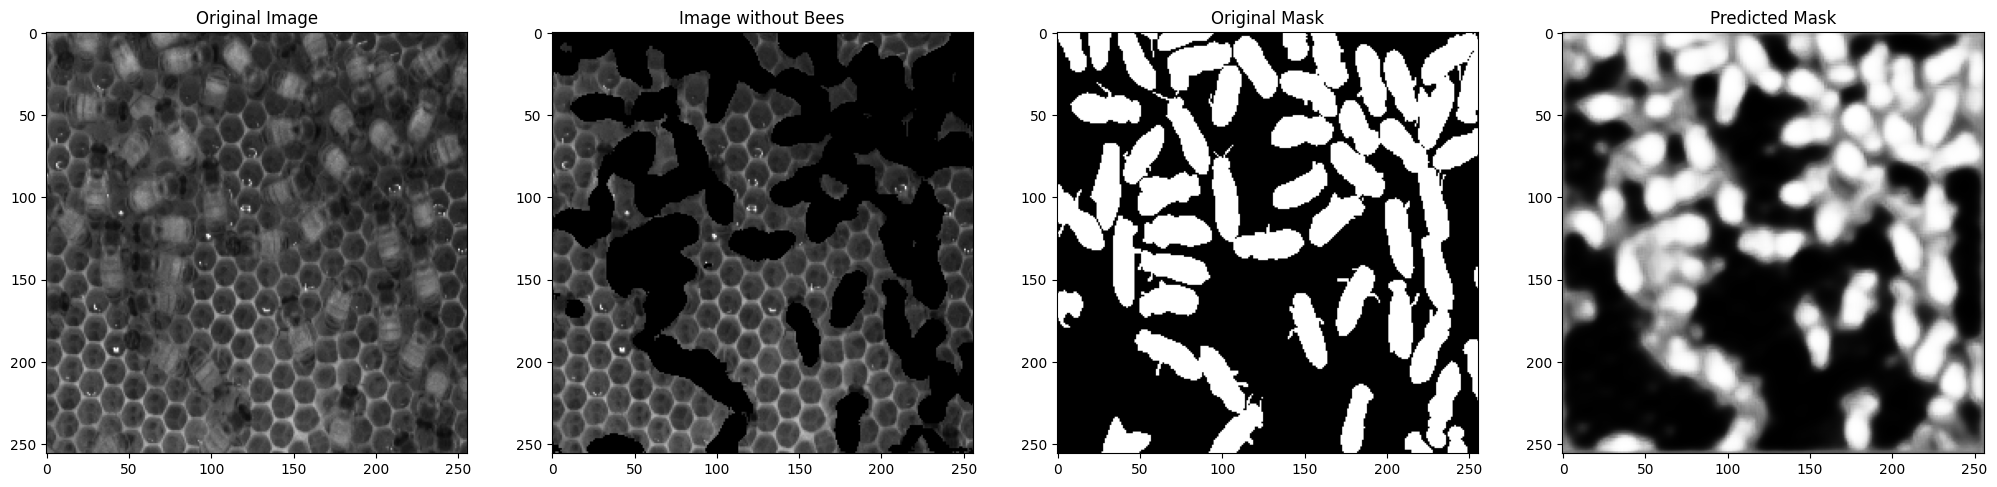

Test IoU: 0.7336028218269348
Test Accuracy: 0.8451004028320312
Test Recall: 0.888323279013562
Test Precision: 0.8073576875180302
Test F1 Score: 0.8458227432416425


In [9]:
# Evaluate on the test set

# Denormalize function:
def denormalize(image, mean, std):
    image = image.clone().cpu().numpy()
    image = image.transpose(1, 2, 0)
    image = (image * std) + mean
    image = np.clip(image * 255, 0, 255).astype(np.uint8)  # Rescale back to [0,255]
    return image

# Function to remove bees from the image based on the predicted mask
def remove_bees(image, predicted_mask):
    # Convert the predicted mask to binary
    binary_mask = (predicted_mask > 0.5).astype(np.float32)
    inverse_mask = 1 - binary_mask
    image_without_bees = image * inverse_mask[..., None]  # Apply the inverse mask to the image
    return image_without_bees.astype(np.uint8)

# Model evaluation:
model.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Image normalization parameters used previously
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Initialize metrics
total_iou, total_acc, total_recall, total_precision, total_fscore = 0, 0, 0, 0, 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        iou, accuracy, recall, precision, f_score = get_metrics(outputs, masks)
        total_iou += iou
        total_acc += accuracy
        total_recall += recall
        total_precision += precision
        total_fscore += f_score
        
        # Visualize the images
        fig, ax = plt.subplots(1, 4, figsize=(25, 6))
        
        denorm_img = denormalize(images[0], mean, std)
        ax[0].imshow(denorm_img)
        ax[0].set_title("Original Image")
        
        image_without_bees = remove_bees(denorm_img, outputs[0][0].cpu().numpy())
        ax[1].imshow(image_without_bees)
        ax[1].set_title("Image without Bees")
        
        ax[2].imshow(masks[0][0].cpu().numpy(), cmap="gray")
        ax[2].set_title("Original Mask")
        
        ax[3].imshow(outputs[0][0].cpu().numpy(), cmap="gray")
        ax[3].set_title("Predicted Mask")
        
        plt.show()

# Average the metrics
num_test_samples = len(test_loader)
print(f"Test IoU: {total_iou/num_test_samples}")
print(f"Test Accuracy: {total_acc/num_test_samples}")
print(f"Test Recall: {total_recall/num_test_samples}")
print(f"Test Precision: {total_precision/num_test_samples}")
print(f"Test F1 Score: {total_fscore/num_test_samples}")


## Apply the model to new images

### EDIT

Input, output folders and model_path will need to be changed to personal folders/files. The model_path that you set previously should be copied to match for this code chunk. The input folder should consist of the initial images to be run through the algorithm. The output folder should be an empty folder that will store the sub-images after the bees have been removed. The final_output_folder should also be empty. This will save the final images without bees.

There is one line to be changed at the top and two at the bottom.

Note: had to change 'MP4V' to 'mp4v' to work on mac. Also had to change '

In [12]:
import os
import cv2
import numpy as np
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

# Load the model and other variables outside of the function

#TODO: change to local folder
model_path = "/Users/enhatl/Desktop/Capstone Proj/UNETPLUSPLUS_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define albumentations transformations
valid_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# --- Functions for Image Processing ---

def preprocess_image(image_np, transform):
    # Ensure the image is in float32 format
    if image_np.dtype != np.float32:
        image_np = image_np.astype(np.float32)

    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    augmented = transform(image=image_np)
    return augmented['image']

def remove_bees_from_image(image, predicted_mask):
    # Resize the predicted mask to the size of the original image
    resized_mask = cv2.resize(predicted_mask, (image.shape[1], image.shape[0]))

    # Create a binary mask
    binary_mask = (resized_mask > 0.5).astype(np.float32)

    # Get the inverse of the mask
    inverse_mask = 1 - binary_mask

    # Remove bees from the image
    image_without_bees = image * inverse_mask.squeeze()

    return image_without_bees.astype(np.uint8)

def process_image(image_path, transform):
    image = Image.open(image_path)
    width, height = image.size
    split_width = width // 3
    split_height = height // 3

    # Create an empty array to store processed parts
    processed_parts = []

    for i in range(3):
        for j in range(3):
            left = i * split_width
            upper = j * split_height
            right = left + split_width
            lower = upper + split_height
            region = image.crop((left, upper, right, lower))
            sub_image_np = np.array(region)
            sub_image_tensor = preprocess_image(sub_image_np, transform).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(sub_image_tensor)

            predicted_mask = output[0][0].cpu().numpy()
            sub_image_without_bees = remove_bees_from_image(sub_image_np, predicted_mask)
            processed_parts.append(sub_image_without_bees)

    # Reassemble the full image from processed parts (for grayscale images)
    reassembled_image = np.zeros((height, width), dtype=np.uint8)
    for i in range(3):
        for j in range(3):
            reassembled_image[j * split_height:(j + 1) * split_height,
                              i * split_width:(i + 1) * split_width] = processed_parts[i * 3 + j]

    return Image.fromarray(reassembled_image)

def process_subfolder(subfolder_path, transform):
    image_files = sorted([os.path.join(subfolder_path, img) for img in os.listdir(subfolder_path) if img.endswith('.png')])
    reassembled_images_list = []

    # Determine the resolution of the first image in the sequence
    first_image = Image.open(image_files[0])
    first_image_width, first_image_height = first_image.size

    # Initialize the accumulated_comb array with the first image's dimensions
    accumulated_comb = np.zeros((first_image_height, first_image_width), np.float32)

    for image_file in image_files:
        reassembled_image = process_image(image_file, transform)
        image_np = np.array(reassembled_image)

        if len(image_np.shape) == 3:
            image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

        # Ensure the image matches the dimensions of the accumulated_comb
        if image_np.shape != accumulated_comb.shape:
            image_np = cv2.resize(image_np, (first_image_width, first_image_height))

        accumulated_comb = np.maximum(accumulated_comb, image_np)
        reassembled_images_list.append(accumulated_comb.copy())

    return reassembled_images_list

def create_timelapse(input_folder, output_video, transform):
    subfolders = [os.path.join(input_folder, sub) for sub in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, sub))]

    # Determine the resolution of the first image in the sequence
    first_image_path = os.path.join(subfolders[0], os.listdir(subfolders[0])[0])
    first_image = Image.open(first_image_path)
    first_image_width, first_image_height = first_image.size

    # Initialize the accumulated_comb array with the first image's dimensions
    accumulated_comb = np.zeros((first_image_height, first_image_width), np.float32)

    # Define the codec and create VideoWriter object with the first image's dimensions
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, 4, (first_image_width, first_image_height), isColor=False)

    for subfolder in subfolders:
        image_files = sorted([os.path.join(subfolder, img) for img in os.listdir(subfolder) if img.endswith('.png')])

        for image_file in image_files:
            reassembled_image = process_image(image_file, transform)
            image_np = np.array(reassembled_image)

            # Ensure the image matches the dimensions of the accumulated_comb
            if image_np.shape != accumulated_comb.shape:
                image_np = cv2.resize(image_np, (first_image_width, first_image_height))

            accumulated_comb = np.maximum(accumulated_comb, image_np)
            frame_gray = np.uint8(accumulated_comb)
            frame_colored = cv2.cvtColor(frame_gray, cv2.COLOR_GRAY2BGR)
            out.write(frame_colored)
    out.release()
    print(f'The timelapse video has been saved as {output_video}')


#TODO: change to local folder

input_folder = "/Users/enhatl/Downloads/cam1_25mm-selected"
output_video = "/Users/enhatl/Desktop/Capstone Proj/test.mp4"
create_timelapse(input_folder, output_video, valid_transform)